## ***AISdb*** Quick Start Tutorial

This notebook walks through the AIS data preprocessing pipeline using **AISdb**.
You will find examples of database connections, various query types, data cleaning approaches, segmentation methods, interpolation techniques, and feature calculations.

To better support our users' work, we have prepared these additional resources:

- Latest release available in our [GitHub repository](https://github.com/AISViz/AISdb)
- Documentation and tutorials in our [GitBook](https://aisviz.gitbook.io/documentation)
- Full list of [notebooks](https://github.com/AISViz/Tutorials) with code examples available in the [**AISViz**](https://github.com/AISViz) GitHub account
- [API documentation](https://aisviz.cs.dal.ca/AISdb/) for quick function reference

## Installing Required Packages

In [ ]:
%%capture
!pip install aisdb cartopy

## Loading Required Packages

In [1]:
import os
import aisdb
import pickle
import numpy as np
import pandas as pd
import nest_asyncio
import geopandas as gpd
import cartopy.crs as ccrs
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import cartopy.feature as cfeature
from aisdb import DBConn, DBQuery, DomainFromPoints
from aisdb.database.dbconn import PostgresDBConn
from shapely.geometry import Point, MultiPoint
from aisdb.webdata.shore_dist import CoastDist
from aisdb.webdata.shore_dist import ShoreDist
from aisdb.webdata.shore_dist import PortDist
from datetime import datetime, timedelta
from aisdb.gis import DomainFromTxts
from aisdb.database import sqlfcn
from shapely import prepare
from PIL import ImageFile
from tqdm import tqdm
nest_asyncio.apply()
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Database Connection

This code establishes a connection to a PostgreSQL database containing AIS data. 

In [2]:
# >>> PostgreSQL Information <<<
db_user='username'            # DB User
db_dbname='dbname'         # DB Schema
db_password='password'    # DB Password
db_hostaddr='127.0.0.1'    # DB Host address

dbconn = PostgresDBConn(
    port=5588,             # PostgreSQL port
    user=db_user,          # PostgreSQL username
    dbname=db_dbname,      # PostgreSQL database
    host=db_hostaddr,      # PostgreSQL address
    password=db_password,  # PostgreSQL password
)

## Custom Visualization Function (not included on AISdb)

The following function is intended to visualize AIS tracks on a map. It takes the trajectory data, along with optional parameters for styling (dot size, color, line properties), and creates a map with coastlines, oceans, land, borders, lakes, and rivers. It can display tracks as either points (dots) or lines, allowing for customization of the visualization. If desired, the generated map can be saved to a file.

In [3]:
def map_view(tracks, dot_size=3, color=None, save=False, path=None, bbox=None, line=False, line_width=0.5, line_opacity=0.3):
    fig = plt.figure(figsize=(16, 9))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Add cartographic features
    ax.add_feature(cfeature.OCEAN.with_scale('10m'), facecolor='#E0E0E0')
    ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor='#FFE5CC')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    ax.coastlines(resolution='10m')

    if line:
        for track in tqdm(tracks):
            ax.plot(track['lon'], track['lat'], color=color, linewidth=line_width, alpha=line_opacity, transform=ccrs.PlateCarree())
    else:
        for track in tqdm(tracks):
            ax.scatter(track['lon'], track['lat'], c=color, s=dot_size, transform=ccrs.PlateCarree())

    if bbox:
        # Set the map extent based on a bounding box
        ax.set_extent(bbox, crs=ccrs.PlateCarree())

    ax.gridlines(draw_labels=True)

    if save:
        plt.savefig(path, dpi=300, transparent=True)

    plt.show()

## Query **by time range and area**

This code defines a geographical bounding box using coordinates (xmin, ymin, xmax, ymax) and a time range from January 1, 2023 to January 10, 2023. It then constructs a database query (DBQuery) to retrieve AIS tracks within this specified region and time frame, filtering for valid MMSI numbers. The retrieved tracks are stored in the `ais_tracks` list for further processing or analysis.

100%|████████████████████████████████████████████████████| 364/364 [00:00<00:00, 1697.02it/s]


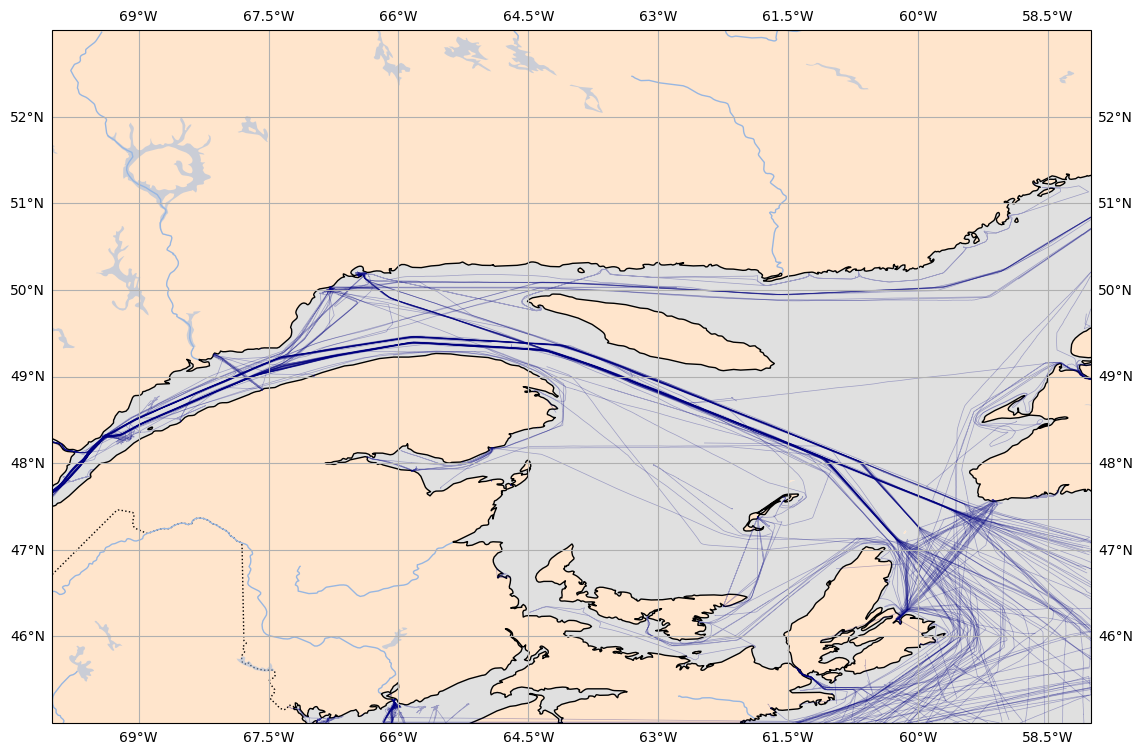

In [4]:
xmin, ymin, xmax, ymax = -70, 45, -58, 53
gulf_bbox = [xmin, xmax, ymin, ymax]
start_time = datetime(2023, 1, 1)
end_time = datetime(2023, 1, 10)

qry = DBQuery(
    dbconn=dbconn,
    start=start_time, end=end_time,
    xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax,
    callback=aisdb.database.sqlfcn_callbacks.in_time_bbox_validmmsi
)

ais_tracks = []
rowgen = qry.gen_qry()
tracks = aisdb.track_gen.TrackGen(rowgen, decimate=False)
ais_tracks.extend(tracks)

map_view(ais_tracks, color='navy', bbox=gulf_bbox, line=True)

## Query **all by time range**

This code queries an AIS database for vessel tracks within a specific time and geographical area using a DBQuery. It retrieves all AIS tracks between January 1st, 2023 00:00:00 and January 2nd, 2023 00:00:00 that stored in AISdb (mainly covering North America), and filters for valid MMSI numbers. The results are stored in `time_tracks` and visualized on a map using `map_view()` function.

100%|████████████████████████████████████████████████| 10801/10801 [00:06<00:00, 1775.61it/s]


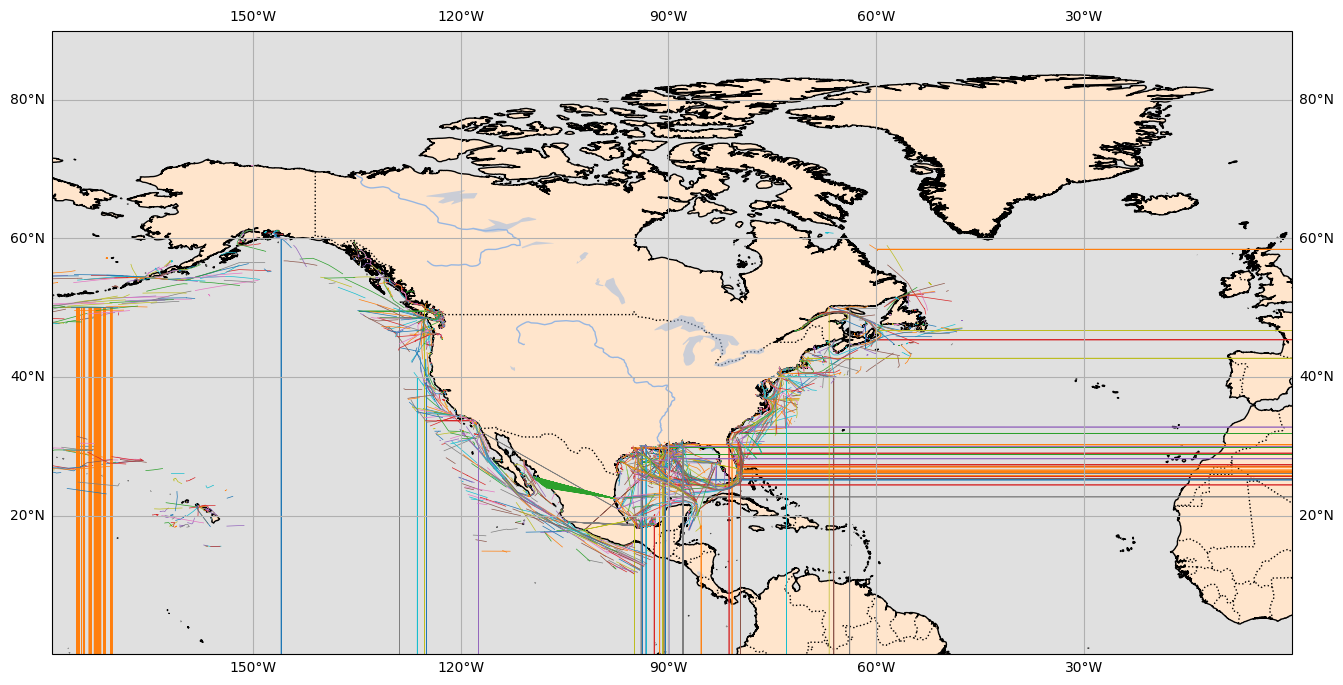

In [5]:
qry = aisdb.DBQuery(
    start=datetime.strptime("2023-01-01 00:00:00", '%Y-%m-%d %H:%M:%S'),
    end=datetime.strptime("2023-01-02 00:00:00", '%Y-%m-%d %H:%M:%S'),
    callback=aisdb.database.sqlfcn_callbacks.in_time_bbox_validmmsi,
    dbconn=dbconn, xmin=-179, xmax=0, ymin=0, ymax=90,
)
time_tracks = []
tracks = aisdb.track_gen.TrackGen(qry.gen_qry(), decimate=False)
time_tracks.extend(tracks)

map_view(time_tracks, line=True, line_opacity=1, bbox=[-179, 0, 0, 90])

## Query **by MMSI**

This code queries an AIS database for tracks of a specific vessel identified by its MMSI (316037746), focusing on movements within the Gulf of St. Lawrence from January 1st to April 1st, 2023. Using a `DBQuery` with a callback function, it stores the retrieved tracks in `mmsi_tracks` and displays them on a map within the specified `gulf_bbox` boundary.

100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 350.49it/s]


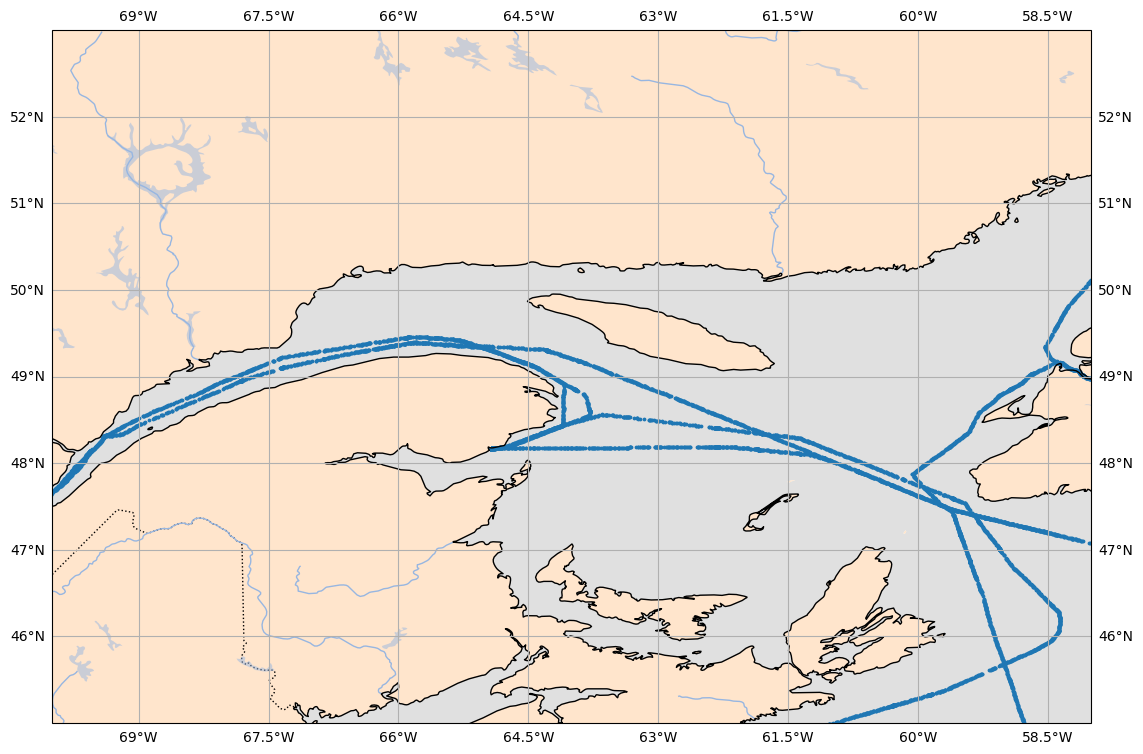

In [6]:
qry = DBQuery(
    dbconn=dbconn,
    start=datetime(2023, 1, 1), end=datetime(2023, 4, 1),
    xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax, mmsi=316037746,
    callback=aisdb.database.sqlfcn_callbacks.in_timerange_hasmmsi,
)

tracks = aisdb.track_gen.TrackGen(qry.gen_qry(), decimate=False)

mmsi_tracks = []
mmsi_tracks.extend(tracks)
map_view(mmsi_tracks, bbox=gulf_bbox)

## Query **by ship types**

This code queries an AIS database for vessel tracks within a 50km radius of (-63.6, 44.6) between January 1st and 2nd, 2023. Using a `DBQuery`, it retrieves both dynamic and static AIS data. Finally, it prints the ship type and its description for the first track.

In [7]:
domain = DomainFromPoints(points=[(-63.6, 44.6)], radial_distances=[50000])
start_time, end_time = datetime(2023, 1, 1), datetime(2023, 1, 2)

qry = DBQuery(
    dbconn=dbconn, start=start_time, end=end_time,
    xmin=domain.boundary['xmin'], xmax=domain.boundary['xmax'],
    ymin=domain.boundary['ymin'], ymax=domain.boundary['ymax'],
    callback=aisdb.database.sqlfcn_callbacks.in_time_bbox_validmmsi
)

rowgen = qry.gen_qry(fcn=sqlfcn.crawl_dynamic_static)
tracks = aisdb.track_gen.TrackGen(rowgen, decimate=False)

for track in tracks:
    print(track['ship_type'], track['ship_type_txt'])
    break

52 Tug


## Denoising **by speed and distance**

This code denoises AIS tracks in `time_tracks` by removing points exceeding distance (20 km) or speed (50 knots) thresholds using `encode_greatcircledistance` function. The resulting tracks are visualized on a map.

100%|████████████████████████████████████████████████| 10801/10801 [00:06<00:00, 1651.22it/s]


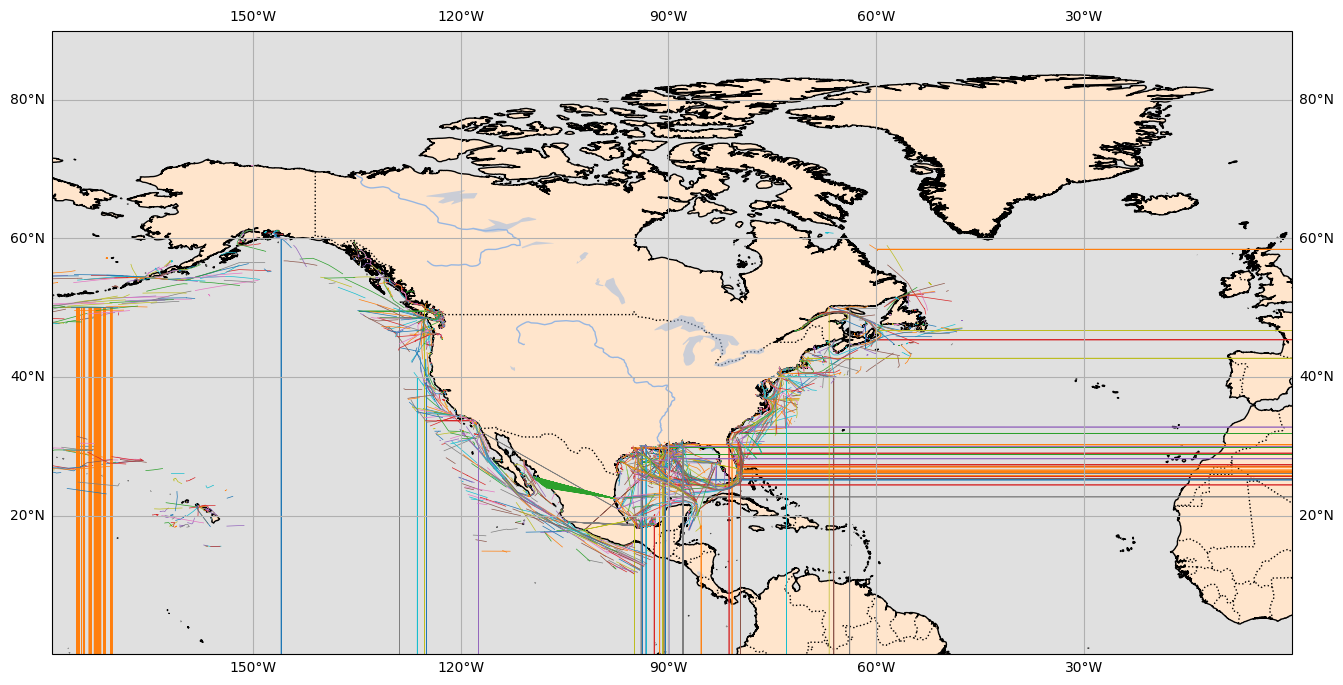

100%|████████████████████████████████████████████████| 11460/11460 [00:06<00:00, 1651.92it/s]


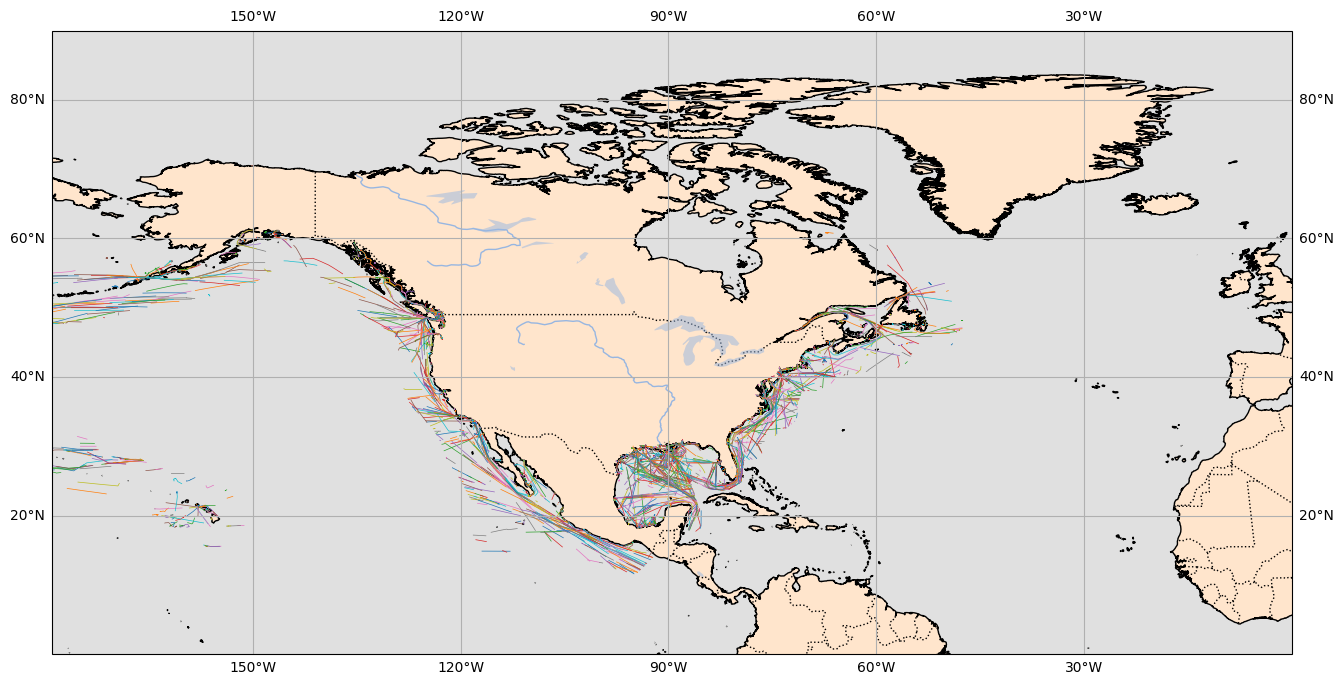

In [8]:
map_view(time_tracks, line=True, line_opacity=1, bbox=[-179, 0, 0, 90])

distance_threshold = 20000 # the maximum allowed distance (meters)
speed_threshold = 50       # the maximum allowed vessel speed (knots)

# Encode the tracks to clean noisy data
tracks_encoded = aisdb.encode_greatcircledistance(
    time_tracks, distance_threshold=distance_threshold, speed_threshold=speed_threshold, minscore=1e-6)

encoded_list = []
encoded_list.extend(tracks_encoded)
map_view(encoded_list, line=True, line_opacity=1, bbox=[-179, 0, 0, 90])

## Segmentation **by time threshold**

This code segments vessel tracks (`mmsi_tracks`) into smaller segments based on a 24-hour time threshold using `split_timedelta`. It then visualizes both the original tracks and the segmented tracks on a map with a specified bounding box (`gulf_bbox`) using the `map_view` function. This segmentation allows for analysis of vessel behavior over shorter, more manageable time periods.

100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 343.06it/s]


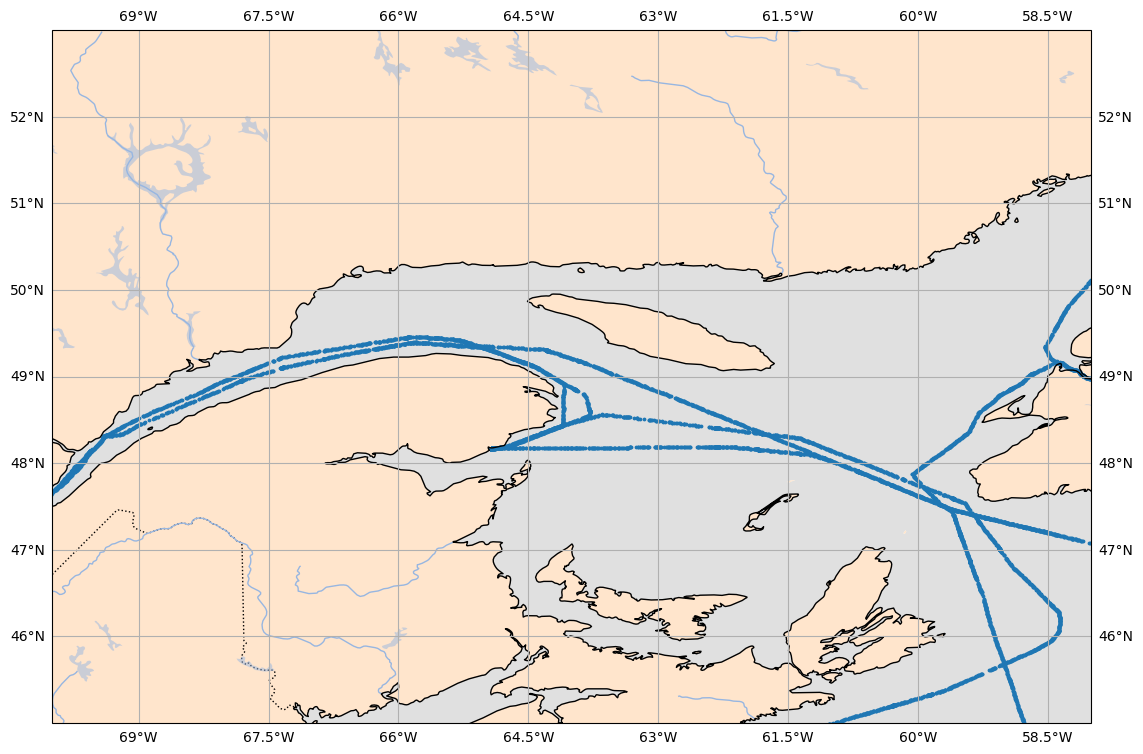

100%|█████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 472.12it/s]


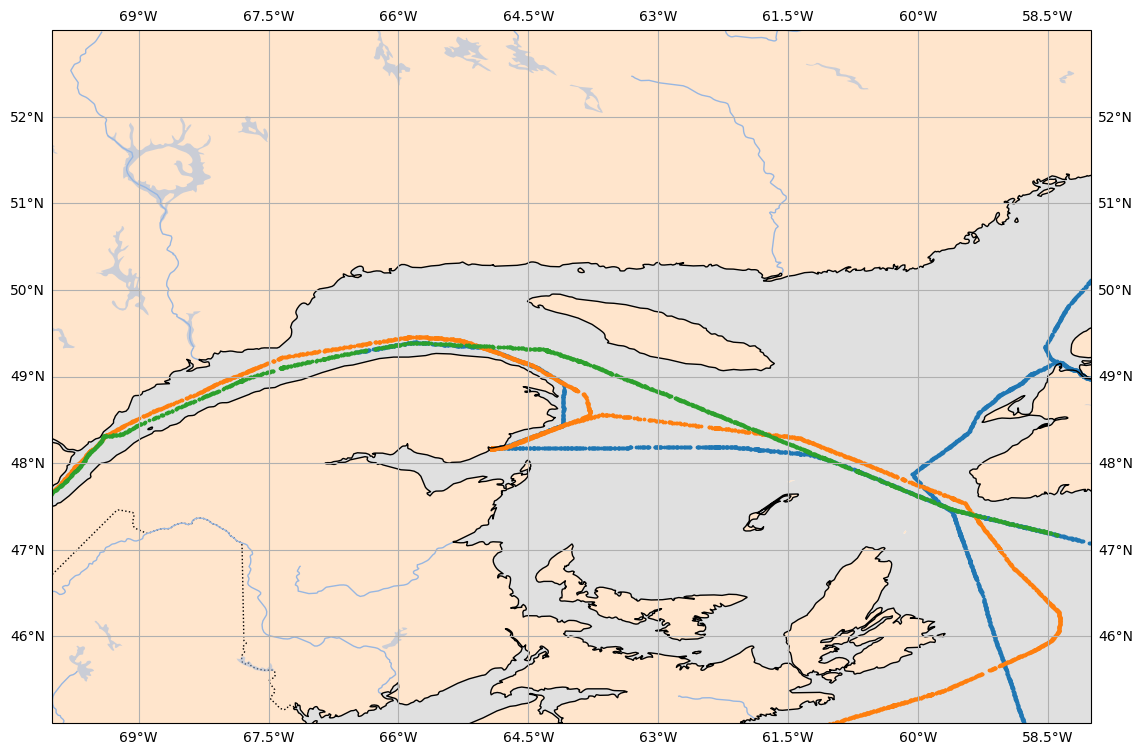

In [9]:
track_segments = aisdb.track_gen.split_timedelta(mmsi_tracks, timedelta(hours=24))

seg_list = []
seg_list.extend(track_segments)
map_view(mmsi_tracks, bbox=gulf_bbox)
map_view(seg_list, bbox=gulf_bbox)

This code queries an AIS database for tracks of a specific vessel (MMSI 636017611) between March 15th and 31st, 2018. It then generates vessel tracks from the query results and visualizes them on a map. Essentially, it retrieves and displays the movement of a particular vessel over a given timeframe.

1it [00:00, 18.11it/s]


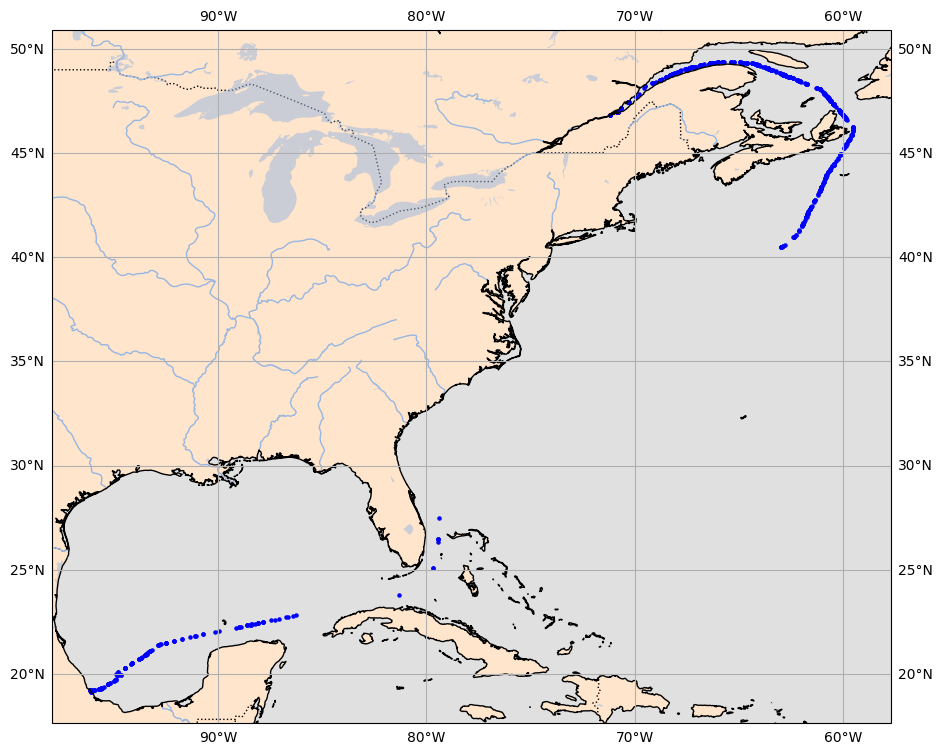

In [10]:
qry = DBQuery(
    dbconn=dbconn, mmsi=636017611,
    start=datetime(2018, 3, 15), end=datetime(2018, 3, 31),
    callback=aisdb.database.sqlfcn_callbacks.in_timerange_hasmmsi)
tracks = aisdb.track_gen.TrackGen(qry.gen_qry(), decimate=False)
map_view(tracks, color='blue', dot_size=5)

## Trajectory **Linear Interpolation**

This code retrieves AIS tracks for a specific vessel (MMSI 636017611) within a defined time range (March 15th to 31st, 2018). It then applies linear interpolation to these tracks using a 60-minute time window, effectively estimating vessel positions at regular intervals. Finally, it visualizes the interpolated track on a map using blue dots. This process enhances the track's temporal resolution for analysis.

1it [00:00, 18.40it/s]


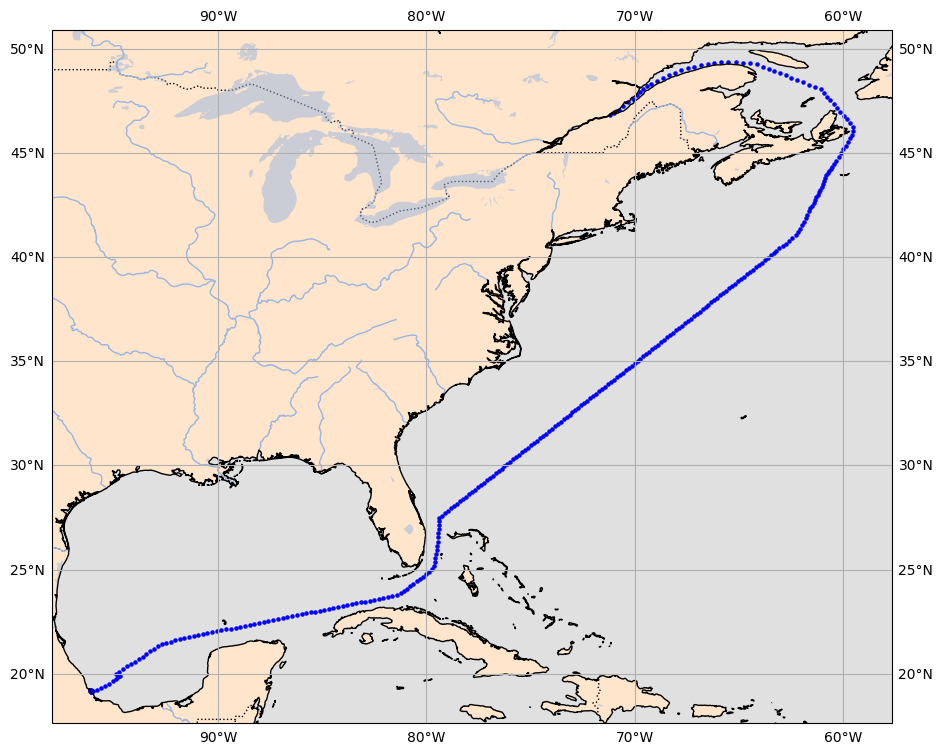

In [11]:
qry = DBQuery(
    dbconn=dbconn, mmsi=636017611,
    start=datetime(2018, 3, 15), end=datetime(2018, 3, 31),
    callback=aisdb.database.sqlfcn_callbacks.in_timerange_hasmmsi
)
tracks = aisdb.track_gen.TrackGen(qry.gen_qry(), decimate=False)
track_interp = aisdb.interp.interp_time(tracks, timedelta(minutes=60))
map_view(track_interp, color='blue', dot_size=5)

This code queries AIS data for a specific vessel (MMSI 636017611) between March 15th and 31st, 2018. It then applies linear interpolation to the vessel's track, ensuring data points are spaced approximately 1000 meters apart. Finally, the interpolated track is visualized on a map using blue dots. This interpolation method focuses on spatial regularity rather than temporal consistency.

1it [00:00,  6.33it/s]


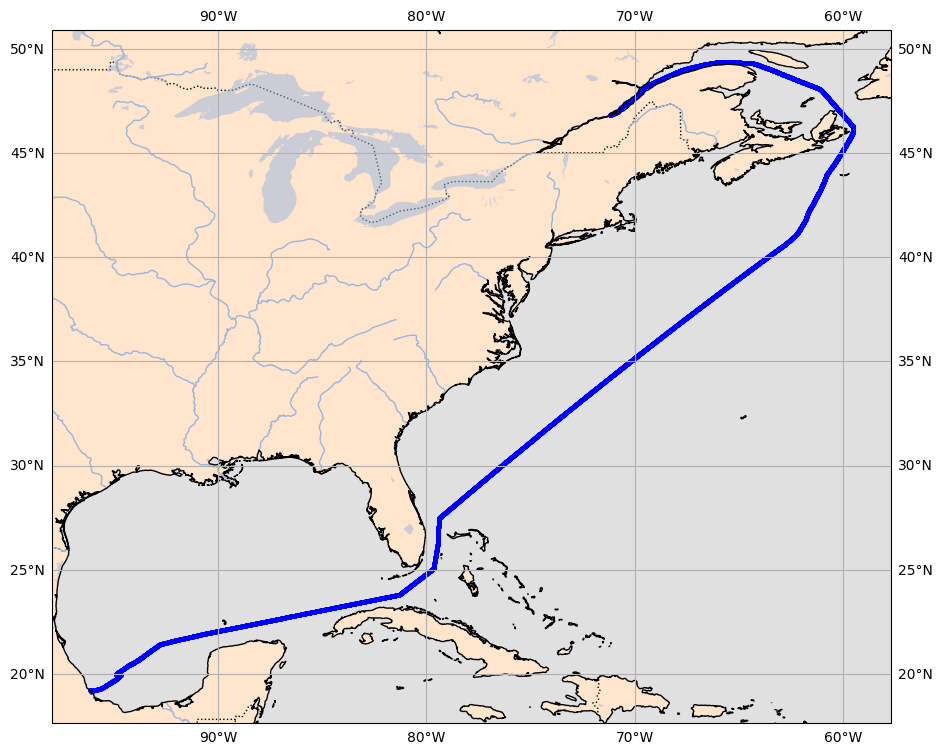

In [12]:
qry = DBQuery(
    dbconn=dbconn, mmsi=636017611,
    start=datetime(2018, 3, 15), end=datetime(2018, 3, 31),
    callback=aisdb.database.sqlfcn_callbacks.in_timerange_hasmmsi,
)
tracks = aisdb.track_gen.TrackGen(qry.gen_qry(), decimate=False)
track_interp = aisdb.interp.interp_spacing(spacing=1000, tracks=tracks)
map_view(track_interp, color='blue', dot_size=5)

## Trajectory **Geodesic Interpolation**

This code retrieves AIS tracks for a specific vessel (MMSI 636017611) within a defined time range (March 15th to 31st, 2018). It then applies geodesic interpolation, estimating the vessel's positions every 10 minutes along its route while considering Earth's curvature. Finally, it visualizes the interpolated track on a map. This method results more accurate interpolation for long-distance maritime routes.

1it [00:00,  8.75it/s]


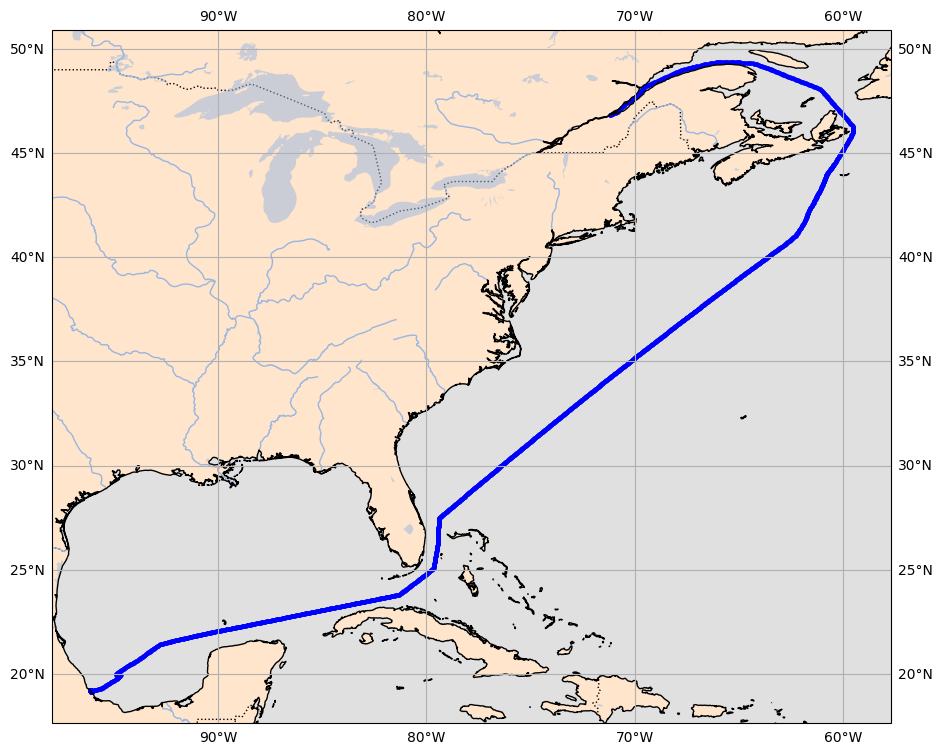

In [13]:
qry = DBQuery(
    dbconn=dbconn, mmsi=636017611,
    start=datetime(2018, 3, 15), end=datetime(2018, 3, 31),
    callback=aisdb.database.sqlfcn_callbacks.in_timerange_hasmmsi,
)
tracks = aisdb.track_gen.TrackGen(qry.gen_qry(), decimate=False)
track_interp = aisdb.interp.geo_interp_time(tracks, timedelta(minutes=10))
map_view(track_interp, color='blue', dot_size=5)

## Trajectory **Cubic Spline Interpolation**

1it [00:00, 16.74it/s]


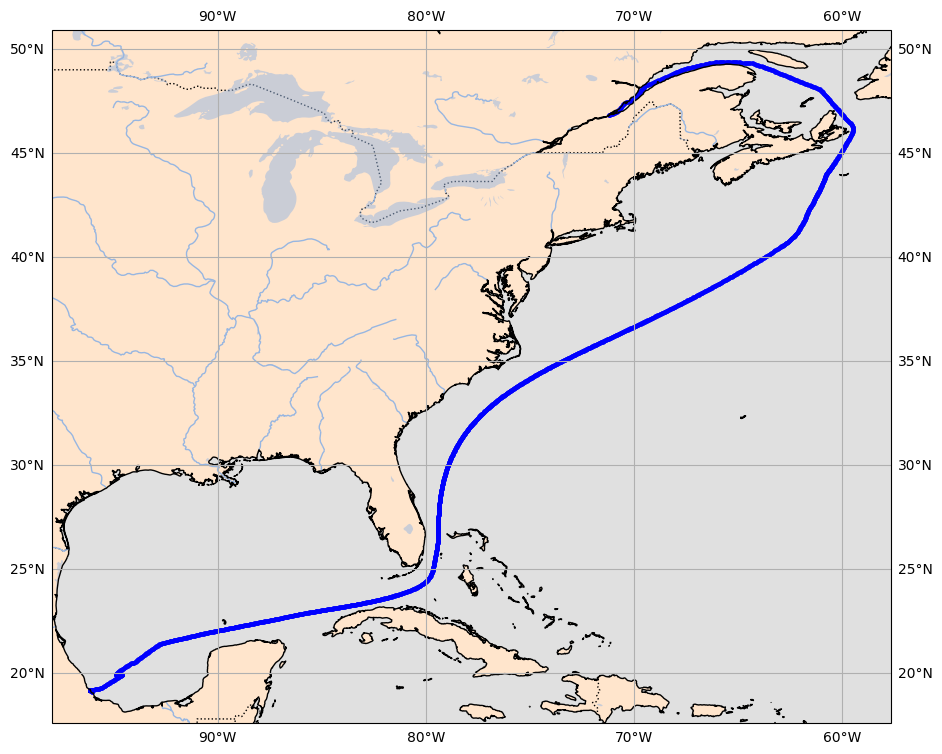

In [14]:
qry = DBQuery(
    dbconn=dbconn, mmsi=636017611,
    start=datetime(2018, 3, 15), end=datetime(2018, 3, 31),
    callback=aisdb.database.sqlfcn_callbacks.in_timerange_hasmmsi,
)
tracks = aisdb.track_gen.TrackGen(qry.gen_qry(), decimate=False)
track_interp = aisdb.interp.interp_cubic_spline(tracks, timedelta(minutes=10))
map_view(track_interp, color='blue', dot_size=5)

## Metrics and distance calculation​

This code queries an AIS database for tracks of a specific vessel (MMSI 316037746) within a time period (January 1st, 2023, from 00:00:00 to 12:00:00). It then generates the vessel's track from the query results and visualizes it on a map. Essentially, it retrieves and displays the movement of a particular vessel during a 12-hour window.

100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 456.60it/s]


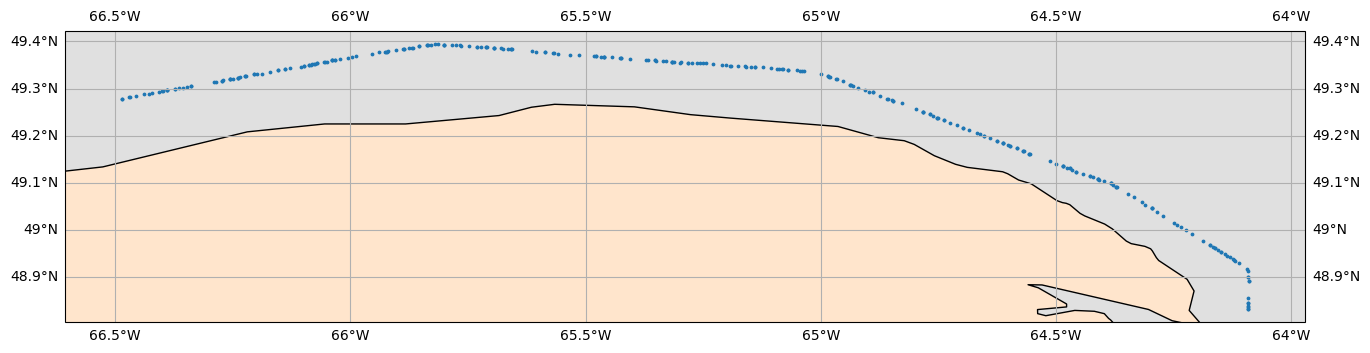

In [15]:
qry = DBQuery(
    dbconn=dbconn, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax, mmsi=316037746,
    start=datetime.strptime("2023-01-01 00:00:00", '%Y-%m-%d %H:%M:%S'),
    end=datetime.strptime("2023-01-01 12:00:00", '%Y-%m-%d %H:%M:%S'),
    callback=aisdb.database.sqlfcn_callbacks.in_timerange_hasmmsi,
)
tracks = aisdb.track_gen.TrackGen(qry.gen_qry(), decimate=False)

day_track = []
day_track.extend(tracks)
map_view(day_track)

This code calculates the distance in meters between consecutive data points within a vessel's track (`day_track`). It then determines and prints the maximum, minimum, and average distances between these points. This provides insights into the spatial resolution and variability of the track data, helping to understand the frequency of position updates and potential gaps in the recorded movement.

In [16]:
distance_meter = []
for track in day_track:
    distance_meter.append(aisdb.gis.delta_meters(track))

distance_meter = np.array(distance_meter)
print(f'Maximum distance between consecutive data points is {np.max(distance_meter)} m, minimum is {np.min(distance_meter)} m and average is {np.mean(distance_meter)} m.')

Maximum distance between consecutive data points is 3893.7288698217135 m, minimum is 0.0 m and average is 650.7776709442729 m.


This code calculates the speed of a vessel in knots for each segment of its track (`day_track`). It determines and prints the maximum, minimum, and average speeds, providing insights into the vessel's movement dynamics and overall travel characteristics within the recorded timeframe. This information can be valuable for understanding vessel behavior and operational patterns.

In [17]:
for track in day_track:
    speed_knot = np.array(aisdb.gis.delta_knots(track))

print(f'Maximum speed is {np.max(speed_knot)} kn, minimum is {np.min(speed_knot)} kn and average is {np.mean(speed_knot)} kn.')

Maximum speed is 139.861556868684 kn, minimum is 0.0 kn and average is 11.601187191878822 kn.


This code calculates the distance of each point in a vessel's track (`day_track`) from the nearest shore. It uses the `ShoreDist` function to retrieve this distance in kilometers and stores it in the `km_from_shore` attribute of each track point. Finally, it prints the distance from shore for each point, enabling analysis of the vessel's proximity to land throughout its journey.

In [18]:
with ShoreDist(data_dir="./") as sdist:
    for track in sdist.get_distance(day_track):
        assert 'km_from_shore' in track['dynamic']
        assert 'km_from_shore' in track.keys()
        print(track['km_from_shore'])

raster-shore.7z: 100%|███████████████████████████████████| 39.9M/39.9M [00:00<00:00, 113MB/s]


[14 14 13 13 14 14 13 13 13 13 13 14 14 14 13 13 13 13 13 14 14 13 13 13
 13 13 13 13 13 13 13 13 13 13 14 14 14 13 13 13 13 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 14 15 15 15 15 16
 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 15 14 14 14 14 13 13 13 13 13 12
 12 12 12 12 12 12 12 12 12 12 12 11 12 12 11 11 11 11 11 11 11 11 11 11
 11 12 12 12 12 12 11 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 14 13
 13 13 13 13 13 13 13 13 13 13 12 12 12 13 11 12 12 12 11 11 11 11 10 10
  9  9  9 10  9  9  8  8  8  9  9  8  8  8  8  8  8  8  8  8  8  8  8  8
  9  9  8  9  8  8  8  8  7  7  7  7  7  7  7  7  6  6  7  7  7  6  6  6
  7  7  6  6  6  7  7  7  7  7  7  8  7  7  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  7  7  7  8  8  8  9  9  9  9  9 10 10  9 10 10 10
  9  9 10 10 10 10 10 10 10 11 10 10 10  9  9  9  9  9  9  9  9  9]


This code calculates the distance of each point in a vessel's track (`day_track`) from the nearest coastline. It uses the `CoastDist` function to determine this distance in kilometers and adds it as the `km_from_coast` attribute to each track point. Finally, it prints the distance from the coast for each point, providing information about the vessel's proximity to the coastline during its voyage.

In [19]:
with CoastDist(data_dir="./") as cdist:
    for track in cdist.get_distance(day_track):
        assert 'km_from_coast' in track['dynamic']
        assert 'km_from_coast' in track.keys()
        print(track['km_from_coast'])

raster-coast.7z: 100%|███████████████████████████████████| 58.8M/58.8M [00:00<00:00, 108MB/s]


[14 14 15 14 14 14 13 15 14 14 14 14 14 14 13 13 14 14 14 14 14 14 14 14
 14 14 13 13 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 15 15 15 14
 14 14 14 14 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 15 15 15 16 16
 16 16 16 16 18 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 17 17
 17 17 16 16 16 16 16 16 16 16 16 16 16 16 15 15 15 15 13 13 13 13 13 13
 13 13 13 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 11 11 11 11 11
 11 11 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 14
 14 14 14 14 14 14 13 13 13 13 13 12 12 12 12 12 12 12 11 11 11 11 11 10
 10 10 10 10  9  9  9  9  9  9  9  8  8  8  8  8  8  8  8  8  9  9  8  9
  9  9  9  9  9  9  9  8  7  7  8  8  8  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  8  8  8  7  8  8  7  8  8  8  8  8  8  8  9  8  8  8  8
  8  8  9  8  8  8  8  8  8  8  8  8  9  9  9  8 10  9  9  9 10 10  9 10
 10 10  9 10 10 10 10 10 10 10 10  9  9  9  9  8  8  8  8  8  8  8]


This code calculates the distance of each point in a vessel's track (`day_track`) from the nearest port. It utilizes the `PortDist` function to determine this distance in kilometers and stores it in the `km_from_port` attribute of each track point. Finally, it prints the distance from the nearest port for each point, enabling analysis of the vessel's proximity to ports during its movement. This information can be valuable for understanding port visits and potential interactions with port infrastructure.

In [20]:
with PortDist(data_dir="./") as pdist:
    for track in pdist.get_distance(day_track):
        assert 'km_from_port' in track['dynamic']
        assert 'km_from_port' in track.keys()
        print(track['km_from_port'])

raster-ports.7z: 100%|███████████████████████████████████| 1.26G/1.26G [00:11<00:00, 112MB/s]


[ 45.89539719  45.89539719  47.03427505  47.03427505  47.61016846
  49.43816376  50.01800537  50.60165405  51.18898773  51.77987289
  51.77987289  53.01591492  53.01591492  53.01591492  54.19998169
  54.19998169  54.19998169  54.79689789  55.39693451  56.62186813
  56.62186813  59.64665222  59.64665222  61.46715546  61.46715546
  61.46715546  62.07915497  62.07915497  62.07915497  62.69361877
  63.31046677  63.31046677  63.31046677  63.92963409  65.12788391
  65.12788391  65.12788391  65.74589539  65.74589539  66.36611938
  66.98848724  68.23944092  70.05119324  70.05119324  70.67838287
  70.67838287  71.30747223  73.11720276  73.74685669  73.74685669
  74.37828064  74.37828064  75.01143646  75.01143646  75.01143646
  75.01143646  75.64627838  75.64627838  76.8179245   76.8179245
  77.45147705  78.08665466  78.08665466  78.08665466  78.72341156
  78.72341156  79.36172485  81.16373444  81.16373444  81.80224609
  83.72640991  85.52401733  86.16687012  86.81104279  86.81104279
  86.811042

**Tutorial finish!**

In [22]:
xmin, ymin, xmax, ymax = -70, 45, -58, 53
gulf_bbox = [xmin, xmax, ymin, ymax]
start_time = datetime(2023, 1, 1)
end_time = datetime(2023, 1, 10)

qry = DBQuery(
    dbconn=dbconn,
    start=start_time, end=end_time,
    xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax,
    callback=aisdb.database.sqlfcn_callbacks.in_time_bbox_validmmsi
)

ais_tracks = []
rowgen = qry.gen_qry()
tracks = aisdb.track_gen.TrackGen(rowgen, decimate=False)

aisdb.web_interface.visualize(
    tracks,
    # domain=domain,
    visualearth=False,
    open_browser=True,
)

Serving HTTP assets on localhost:3000
Querying database...	done query
Opening a new browser window to display track data. Press Ctrl-C to stop the server and close the webpage


127.0.0.1 - - [13/Jan/2025 09:54:26] "GET /index.html?python=1&z=2 HTTP/1.1" 200 -
127.0.0.1 - - [13/Jan/2025 09:54:26] "GET /assets/main-03f28043.js HTTP/1.1" 200 -
127.0.0.1 - - [13/Jan/2025 09:54:27] "GET /assets/map-2d56ccb9.js HTTP/1.1" 200 -
127.0.0.1 - - [13/Jan/2025 09:54:27] "GET /assets/proj-20c50701.js HTTP/1.1" 200 -
127.0.0.1 - - [13/Jan/2025 09:54:27] "GET /assets/constants-36dce06f.js HTTP/1.1" 200 -
127.0.0.1 - - [13/Jan/2025 09:54:27] "GET /assets/url-af6df854.js HTTP/1.1" 200 -
127.0.0.1 - - [13/Jan/2025 09:54:27] "GET /assets/vessel_metadata-b392cf03.js HTTP/1.1" 200 -
127.0.0.1 - - [13/Jan/2025 09:54:27] "GET /assets/OSM-7b914537.js HTTP/1.1" 200 -
127.0.0.1 - - [13/Jan/2025 09:54:27] "GET /assets/TileImage-204bea65.js HTTP/1.1" 200 -


127.0.0.1:60580 - received: {'msgtype': 'meta'}
127.0.0.1:60582 - received: {'msgtype': 'validrange'}
127.0.0.1:60582 - received: {'msgtype': 'zones'}
Received KeyboardInterrupt, stopping server...
